In [1]:
#import headerfiles

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

In [2]:
credits = pd.read_csv("G:\Study\Szakdolgozat\input\\credits.csv")
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [171]:
metadata = pd.read_csv("G:\Study\Szakdolgozat\input\movies_metadata.csv")
metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
ratings = pd.read_csv("G:\Study\Szakdolgozat\input\\ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [172]:
metadata['genres'] = metadata['genres'].fillna('[unknown]').apply(literal_eval).apply(lambda x : [i['name'] for i in x] if len(x) != 0 else ['Unknown'])
metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,[Drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[Action, Drama, Thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[Unknown],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [169]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  0 non-null      object 
 1   belongs_to_collection  0 non-null      object 
 2   budget                 0 non-null      object 
 3   genres                 0 non-null      object 
 4   homepage               0 non-null      object 
 5   id                     0 non-null      object 
 6   imdb_id                0 non-null      object 
 7   original_language      0 non-null      object 
 8   original_title         0 non-null      object 
 9   overview               0 non-null      object 
 10  popularity             0 non-null      object 
 11  poster_path            0 non-null      object 
 12  production_companies   0 non-null      object 
 13  production_countries   0 non-null      object 
 14  release_date           0 non-null      object 
 15  revenue           

In [173]:
metadata['adult'].describe()

count     45466
unique        5
top       False
freq      45454
Name: adult, dtype: object

In [177]:
metadata = metadata[metadata['adult'] == 'False']
metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,[Drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[Action, Drama, Thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[Unknown],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [178]:
number_of_each_gen = {}
for row in metadata['genres']:
    for genre in row:
        if genre in number_of_each_gen:
            number_of_each_gen[genre] += 1
        else:
            number_of_each_gen[genre] = 1
number_of_each_gen

{'Animation': 1935,
 'Comedy': 13179,
 'Family': 2770,
 'Adventure': 3496,
 'Fantasy': 2313,
 'Romance': 6733,
 'Drama': 20263,
 'Action': 6596,
 'Crime': 4303,
 'Thriller': 7622,
 'Horror': 4670,
 'History': 1398,
 'Science Fiction': 3048,
 'Mystery': 2467,
 'War': 1323,
 'Foreign': 1622,
 'Unknown': 2442,
 'Music': 1597,
 'Documentary': 3932,
 'Western': 1042,
 'TV Movie': 767}

<AxesSubplot:xlabel='Genres', ylabel='Number_of_movies'>

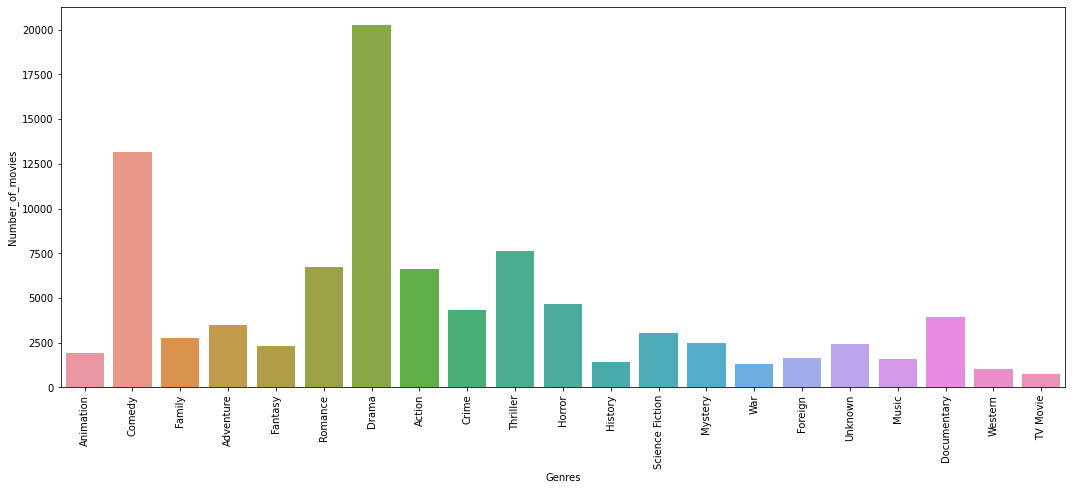

In [179]:
keys = list(number_of_each_gen.keys())
values = [float(number_of_each_gen[k]) for k in keys]
fig, ax = plt.subplots(figsize=(18,7))
plt.xticks(rotation = 90)
plt.ylabel('Number_of_movies')
plt.xlabel('Genres')
sns.barplot(x=keys, y=values,ax = ax)

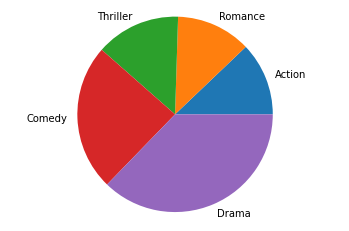

In [180]:
top_5_gen = sorted(number_of_each_gen.items(), key=lambda item : item[1])[-5:]
labels = []
values = []
for gen in top_5_gen:
    labels.append(gen[0])
    values.append(gen[1])
    
plt.pie(values, labels=labels)

plt.axis('equal')
plt.show()


In [181]:
metadata = metadata[metadata['vote_count'].notnull()]

In [182]:
metadata['vote_count'] = metadata['vote_count'].astype(int)
metadata['vote_average'] = metadata['vote_average'].astype(int)

In [183]:
print(metadata['vote_count'].describe(),'\n\n',metadata['vote_average'].describe())

count    45451.000000
mean       109.917538
std        491.356914
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64 

 count    45451.000000
mean         5.245231
std          1.866836
min          0.000000
25%          5.000000
50%          6.000000
75%          6.000000
max         10.000000
Name: vote_average, dtype: float64
